# BIG DATA ANALYTICS - Project - GROUP B

## Group Members

| Student Name | Student ID |
|----------|----------|
| Allyssa Sampath    | 816032362     |
| Avinash Roopnarine    | 816029635     |
| Jared Heeralal    | 816030252     |
| Kimberly Moses   | 816031494     |

#1 IMPORTS

In [489]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score

In [490]:
df = pd.read_excel('HR_Employee_Data.xlsx')

df.head()

,Emp_Id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,IND02438,0.38,0.53,2,157,3,0,1,0,sales,low
1,IND28133,0.80,0.86,5,262,6,0,1,0,sales,medium
2,IND07164,0.11,0.88,7,272,4,0,1,0,sales,medium
3,IND30478,0.72,0.87,5,223,5,0,1,0,sales,low
4,IND24003,0.37,0.52,2,159,3,0,1,0,sales,low


#2 DATA CLEANING / PREPROCESSING

###2.1 Check for missing values
Verify that all data fields are filled. For anomaly detection, only average_work_hours and left categories are important hence precautionary measures will be set for these fields although this dataset used is already cleaned.

In [491]:
# Replace the mispelling of the average_monthly_hours category
if 'average_montly_hours' in df.columns:
  df['average_monthly_hours'] = df['average_montly_hours'].copy()
  df.drop(columns=['average_montly_hours'], inplace=True)

# Check for missing values in the dataset
missing_values = df.isnull().sum()


# Display the number of missing values for each column
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Emp_Id                   0
satisfaction_level       0
last_evaluation          0
number_project           0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
average_monthly_hours    0
dtype: int64


In [492]:
# Handle categorical variables: 'Department' and 'salary'
df = pd.get_dummies(df, columns=['Department', 'salary'])

df.dropna(inplace=True)
df = df.drop(['Emp_Id'], axis=1)


###2.2 Handle missing Average_Monthly_Hours values
To preprocess missing data in this column we will use the average value of the dataset to substitute missing values.

In [493]:
# Calculate the average of non-missing values in the column
average_hours = df['average_monthly_hours'].mean()

# Replace missing values with the average
df['average_monthly_hours'].fillna(average_hours, inplace=True)

###2.3 Handle Missing Left values
To preprocess missing data in this column we will use the average value of the dataset to substitute missing values.

In [494]:
df

,satisfaction_level,last_evaluation,number_project,time_spend_company,Work_accident,left,promotion_last_5years,average_monthly_hours,Department_IT,Department_RandD,...,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,3,0,1,0,157,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,6,0,1,0,262,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,4,0,1,0,272,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,5,0,1,0,223,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,3,0,1,0,159,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,3,0,1,0,151,0,0,...,0,0,0,0,0,1,0,0,1,0
14995,0.37,0.48,2,3,0,1,0,160,0,0,...,0,0,0,0,0,1,0,0,1,0
14996,0.37,0.53,2,3,0,1,0,143,0,0,...,0,0,0,0,0,1,0,0,1,0
14997,0.11,0.96,6,4,0,1,0,280,0,0,...,0,0,0,0,0,1,0,0,1,0


#3 ANOMALY DETECTION

### 3.1 Isolation Forest
A machine learning anomaly detection approach called Isolation Forest is employed. In datasets including both normal and anomalous data points, it is intended to identify outliers or anomalies. Isolation Forest's main concept is to separate out anomalies by first randomly choosing a feature and then choosing a split value at random between the feature's maximum and minimum values. Typically, anomalies are isolated into progressively smaller dataset segments by iteratively repeating this technique.

In [495]:
data = df
print(data['average_monthly_hours'].shape)

(14999,)


With the isolation forest, we have to determine a contamination value which is the expected number of outliers. We will use cross validation to determine the best Contamination value to use for the model.

In [496]:
# Select the feature for anomaly detection
work_hours = data['average_monthly_hours'].values.reshape(-1, 1)

# Define parameters for grid search
param_grid = {'contamination': [0.01, 0.02, 0.03, 0.04, 0.05]}

# Initialize Isolation Forest model
model = IsolationForest()

# Define precision scorer
scorer = make_scorer(precision_score, pos_label=-1, y_true = -1)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorer)
grid_search.fit(work_hours)

# Get the best contamination value
best_contamination = grid_search.best_params_['contamination']

print("Best contamination value:", best_contamination)



Best contamination value: 0.01


Since we have the best Contamination Value, we can use this for our model to perform the Anomaly Detection

In [497]:
# Select the feature for anomaly detection
work_hours = data['average_monthly_hours'].values.reshape(-1, 1)

# Initialize and train the Isolation Forest model
model = IsolationForest(contamination=best_contamination)
model.fit(work_hours)

# Predict outliers/anomalies
outliers = model.predict(work_hours)

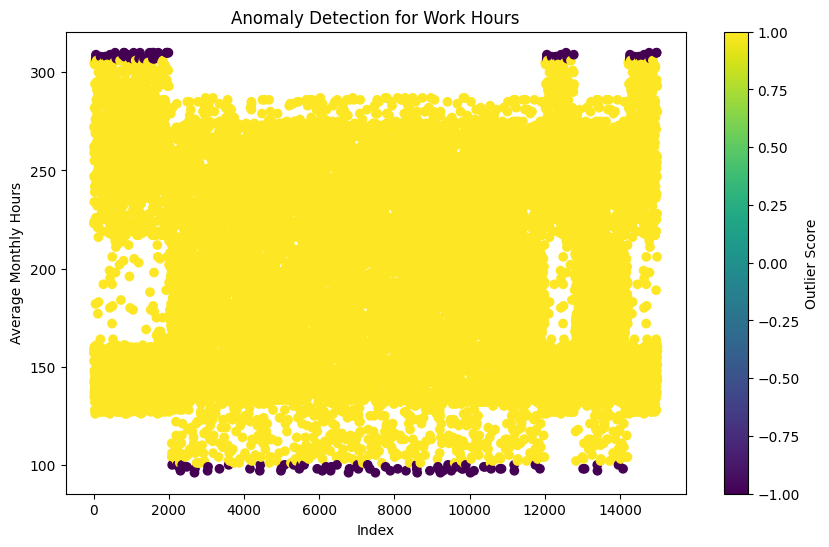

DataFrame of Rows with Anomalies:


,satisfaction_level,last_evaluation,number_project,time_spend_company,Work_accident,left,promotion_last_5years,average_monthly_hours,Department_IT,Department_RandD,...,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,salary_high,salary_low,salary_medium
54,0.10,0.92,7,4,0,1,0,307,0,0,...,0,0,0,0,0,1,0,0,1,0
57,0.10,0.81,6,4,0,1,0,309,0,0,...,0,0,0,0,0,0,1,0,1,0
61,0.11,0.93,7,4,0,1,0,308,1,0,...,0,0,0,0,0,0,0,0,0,1
179,0.11,0.85,6,5,0,1,0,308,0,0,...,0,0,0,0,1,0,0,0,0,1
293,0.11,0.91,6,4,1,1,0,308,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14777,0.11,0.79,7,4,0,1,0,310,0,0,...,1,0,0,0,0,0,0,0,1,0
14810,0.11,0.92,7,4,0,1,0,307,1,0,...,0,0,0,0,0,0,0,0,1,0
14865,0.10,0.89,7,4,0,1,0,308,0,0,...,0,0,0,0,0,0,1,0,0,1
14972,0.11,0.97,6,4,0,1,0,310,0,0,...,0,0,0,0,0,0,0,0,0,1


In [498]:
# Visualize anomalies
plt.figure(figsize=(10, 6))
plt.scatter(range(len(work_hours)), work_hours, c=outliers, cmap='viridis')
plt.xlabel('Index')
plt.ylabel('Average Monthly Hours')
plt.title('Anomaly Detection for Work Hours')
plt.colorbar(label='Outlier Score')
plt.show()

anomaly_indices = data.index[outliers == -1]

# Filter the original DataFrame to include only rows with anomalies
anomaly_df = data.iloc[anomaly_indices]

# Display the DataFrame of rows with anomalies
print("DataFrame of Rows with Anomalies:")
anomaly_df

#4 IDENTIFY ANOMALIES

Using the results of the Isolation Forest the anomalies are separated from the rest of the dataset and the key columns: average_monthly_hours and left are separated for further analysis

In [499]:
final_anomaly = anomaly_df[['average_monthly_hours', 'left']]
final_anomaly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 54 to 14975
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   average_monthly_hours  141 non-null    int64
 1   left                   141 non-null    int64
dtypes: int64(2)
memory usage: 3.3 KB


In [500]:
final_anomaly.shape

(141, 2)

###PieChart Showing the Ratio of Employees at the Company from those who Left

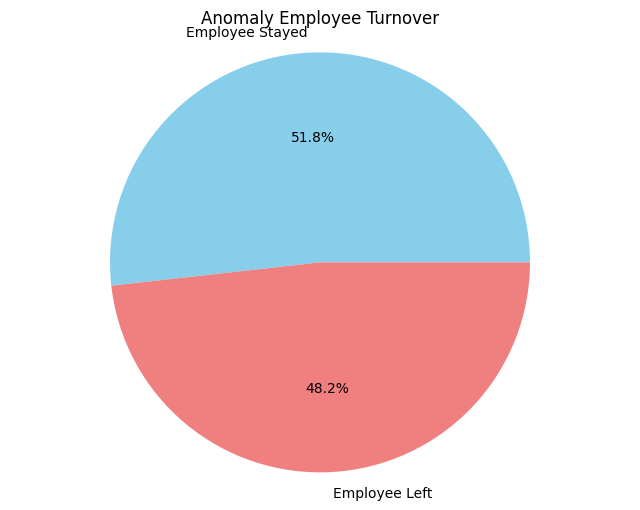

In [501]:
label_dict = {1 : 'Employee Left', 0: 'Employee Stayed'}

# Create a new column with the relabeled values
final_anomaly['left_relabel'] = final_anomaly['left'].map(label_dict)

# Count the occurrences of each category in the 'left_relabel' column
left_counts = final_anomaly['left_relabel'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(left_counts, labels=left_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Anomaly Employee Turnover')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


###Swarmplot showing Average Monthly Hours vs Left

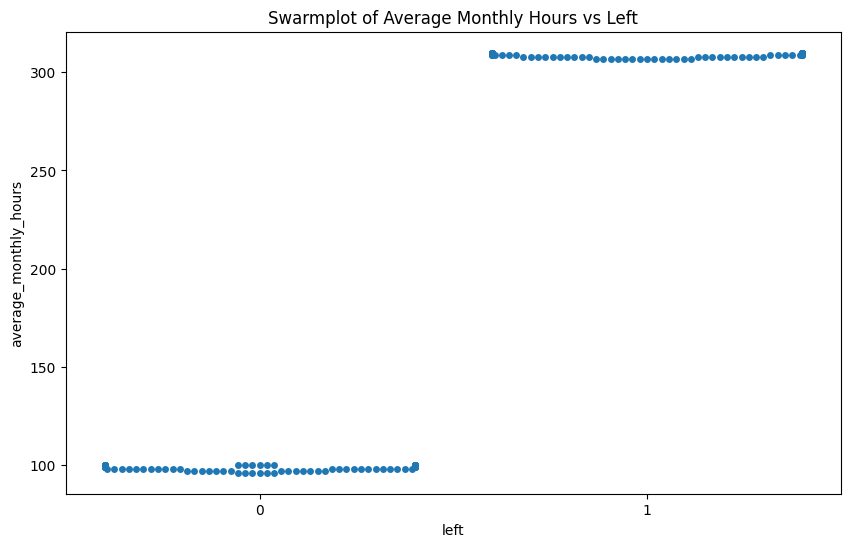

In [502]:
plt.figure(figsize=(10, 6))
sns.swarmplot(x='left', y='average_monthly_hours', data=final_anomaly)
plt.title('Swarmplot of Average Monthly Hours vs Left')
plt.show()

From the Swarmplot Above we can see that all the Anomaly Employees that left the company tend to have high Average Monthly Hours while the Anomaly Emloyees that have low Average Monthly Hours tend to stay a the MNC.

###ScatterPlot visualizing Average Monthly Hours vs Row Index

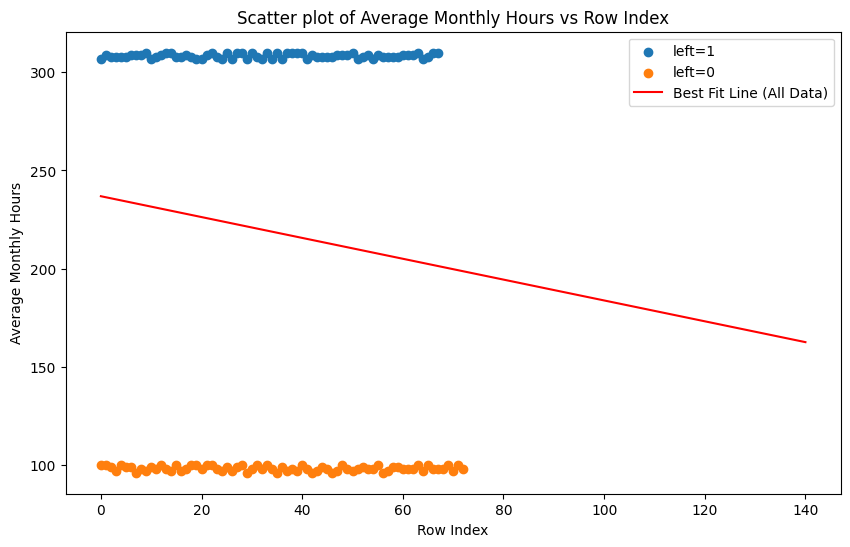

In [503]:
# Create a scatter plot for the left column
plt.figure(figsize=(10, 6))
categories = final_anomaly['left'].unique()
for category in categories:
    data = final_anomaly[final_anomaly['left'] == category]
    plt.scatter(range(len(data)), data['average_monthly_hours'], label=f'left={category}')

# Perform linear regression for all data points
x = np.arange(len(final_anomaly))
y = final_anomaly['average_monthly_hours']
slope, intercept, _, _, _ = linregress(x, y)

# Plot the best-fit line for all data points
plt.plot(x, slope*x + intercept, color='red', label='Best Fit Line (All Data)')

plt.title('Scatter plot of Average Monthly Hours vs Row Index')
plt.xlabel('Row Index')
plt.ylabel('Average Monthly Hours')
plt.legend()
plt.show()

Further visualization on the relationship between left and average monthly hours where High average monthly hours tend to make employees leave the company

#5 CORRELATION ANALYSIS

### Correlation Coefficient Calculation

In [504]:
# Calculate the correlation coefficient
correlation = final_anomaly[['left', 'average_monthly_hours']].corr()

print("Correlation between 'left' and 'average_monthly_hours':")
print(correlation)


Correlation between 'left' and 'average_monthly_hours':
                           left  average_monthly_hours
left                   1.000000               0.999936
average_monthly_hours  0.999936               1.000000


Based on the value obtained there is a strong correlation between Average Monthly Hours and Left as we obtain a Correlation Coefficient of 0.999

###Correlation Analysis Visualization of Average Monthly Hours and Left

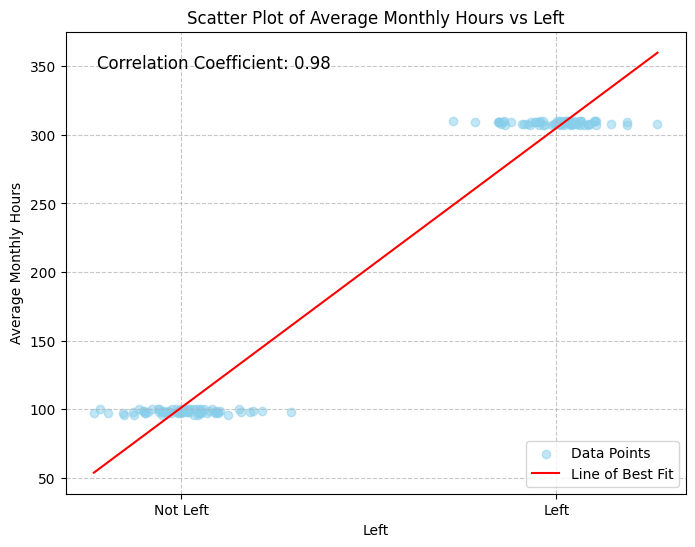

In [505]:
jittered_left = final_anomaly['left'] + np.random.normal(0, 0.1, size=len(final_anomaly))

# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(jittered_left, final_anomaly['average_monthly_hours'])[0, 1]

# Perform linear regression
slope, intercept, _, _, _ = linregress(jittered_left, final_anomaly['average_monthly_hours'])

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(jittered_left, final_anomaly['average_monthly_hours'], alpha=0.5, color='skyblue', label='Data Points')
plt.plot(np.unique(jittered_left), np.poly1d(np.polyfit(jittered_left, final_anomaly['average_monthly_hours'], 1))(np.unique(jittered_left)), color='red', label='Line of Best Fit')
plt.title('Scatter Plot of Average Monthly Hours vs Left')
plt.xlabel('Left')
plt.ylabel('Average Monthly Hours')
plt.xticks([0, 1], ['Not Left', 'Left'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.text(0.05, 0.95, f'Correlation Coefficient: {correlation_coefficient:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='lower right')
plt.show()




As we can see there is a very strong correlation between Average Monthly hours and Left as employees with a Abnormally high average monthly hours tend to leave the MNC while employees with an Abnormally low monthly hours tend to stay at the MNC.